In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [3]:
data = pd.read_csv('data.csv',index_col=0)
data = data.set_index(data.timestamp)
data.head()


,address,x,y,z,timestamp
timestamp,,,,,
2018-07-01 00:55:41.678,-6196490120761152012,-47.9602,-59.9457,6.24468,2018-07-01 00:55:41.678
2018-07-01 00:55:42.923,-6196490120761152012,-46.4965,-60.0888,6.25606,2018-07-01 00:55:42.923
2018-07-01 00:55:44.163,-6196490120761152012,-45.1626,-60.3775,6.46899,2018-07-01 00:55:44.163
2018-07-01 00:55:45.412,-6196490120761152012,-44.1827,-60.4705,6.57457,2018-07-01 00:55:45.412
2018-07-01 00:55:46.704,-6196490120761152012,-43.9995,-60.4705,6.58655,2018-07-01 00:55:46.704


In [4]:
### Convert the data into arrays and remve the first column and the last column from the array which add no informations

data_arr = data.values
data_arr= data_arr[:,1:]
data_arr = data_arr[:,:-1:]
data_arr[0]

array([-47.9602, -59.9457, 6.2446800000000025], dtype=object)

In [5]:
# Remove zero values in axis
data = data[(data != 0).all(1)]
print(len(data))

# Remove zero values in axis
x_data = data_arr[(data_arr != 0).all(1)]
y_data = x_data.copy()
x_data[0]

207639


array([-47.9602, -59.9457, 6.2446800000000025], dtype=object)

#### SIZE OF DATA

In [6]:
num_data = len(x_data)
num_data

207639

#### This is the fraction of the data-set that will be used for the training-set:

In [7]:
train_split = 0.9

In [8]:
num_train = int(train_split * num_data)
num_train

186875

In [9]:
num_test = num_data - num_train
num_test

20764

#### Inputs for the training and test sets

In [10]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

207639

#### These are the output-signals for the training- and test-sets:

In [11]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

207639

#### Number of input-signals:

In [12]:
num_x_signals = x_data.shape[1]
num_x_signals

3

##### Number of output-signals:

In [13]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### Scaling data

In [14]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -68.5928
Max: 23.1883


In [15]:
x_scaler = MinMaxScaler()


#### Scale training data

In [16]:
x_train_scaled = x_scaler.fit_transform(x_train)

C:\Users\saran\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


##### Scale test data

In [18]:
x_test_scaled = x_scaler.transform(x_test)

##### Scale target values

In [19]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\saran\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### Data Generator

###### Array shapes of Input and output

In [20]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(186875, 3)
(186875, 3)


#### Batch data generator : Batch wise training


In [21]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [22]:
batch_size = 128
sequence_length = 900

#### Initialize batch data generator object

In [23]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

##### Test the generator

In [24]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(128, 900, 3)
(128, 900, 3)


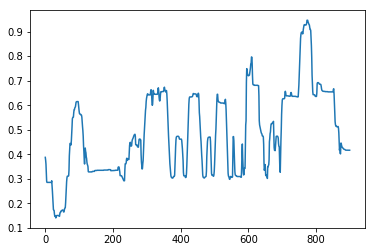

In [25]:
##### Plot the input batch and signal 

batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 3 input-signals (X,Y,Z).
seq = x_batch[batch, :, signal]
plt.plot(seq)

##### Plot the target signal

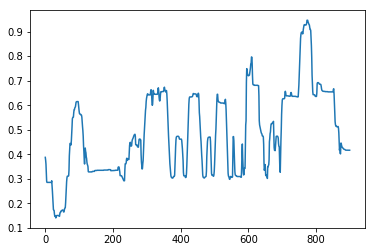

In [26]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation for early stopping

In [27]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

### Recurrent neural network model

In [28]:
model = Sequential()

In [29]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

In [30]:
model.add(Dense(num_y_signals, activation='sigmoid'))

### Visualizing the graph

#### Convert the model into tensorflow as .pb file 

In [33]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

#### Save keras model as tf pb file

In [36]:
from tensorflow.keras import backend as K

In [39]:
frozen_graph = freeze_session(K.get_session(),output_names = [out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph,os.getcwd(),'modelgraph',as_text= False)

INFO:tensorflow:Froze 5 variables.
INFO:tensorflow:Converted 5 variables to const ops.


'N:\\time-series-forecasting\\modelgraph'

#### Load the pb file using tensorflow

In [42]:
from tensorflow.python.platform import gfile

with tf.Session() as sess:
    # Load the model from pb file
    
    with gfile.FastGFile(os.getcwd()+'/'+'modelgraph','rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in= tf.import_graph_def(graph_def)

Instructions for updating:
Use tf.gfile.GFile.


ValueError: Input 0 of node import/gru/while/ReadVariableOp/Enter was passed float from import/gru/kernel:0 incompatible with expected resource.

In [ ]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

In [ ]:
warmup_steps = 50

In [ ]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [ ]:
optimizer = RMSprop(lr=1e-3)

In [ ]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [ ]:
model.summary()

In [ ]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

#### Train the Recurrent Neural Network

In [ ]:
%%time

model.fit_generator(generator=generator,
                    epochs=10,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

In [ ]:
### Load the checkpoint weights

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [ ]:
### Performance on test set

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

In [ ]:
print("loss (test-set):", result)

In [ ]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):   # One one metric 'Loss'
        print("{0}: {1:.3e}".format(metric, res))

### Generate predictions

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

In [ ]:
target_names = ['x','y','z']
plot_comparison(start_idx=100000, length=1000, train=True)

In [ ]:
plot_comparison(start_idx=0, length=10000, train=False)